In [ ]:
import os
import json

def merge_coco_annotations(root_folder, output_file):
    """
    지정된 폴더와 그 하위 폴더의 모든 COCO JSON 파일을 병합합니다.

    Args:
        root_folder (str): 검색을 시작할 최상위 폴더 경로
        output_file (str): 병합된 결과를 저장할 파일 이름
    """
    merged_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_ids = set()
    image_ids = set()
    annotation_id_counter = 1

    # 지정된 폴더 및 하위 폴더 탐색
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.json'):
                json_path = os.path.join(dirpath, filename)
                print(f"처리 중: {json_path}")

                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    # 카테고리 병합 (중복 방지)
                    if 'categories' in data:
                        for category in data['categories']:
                            if category['id'] not in category_ids:
                                merged_data['categories'].append(category)
                                category_ids.add(category['id'])

                    # 이미지 정보 병합 (중복 방지)
                    if 'images' in data:
                        for image in data['images']:
                            if image['id'] not in image_ids:
                                merged_data['images'].append(image)
                                image_ids.add(image['id'])

                    # 어노테이션 병합 (ID 재설정)
                    if 'annotations' in data:
                        for ann in data['annotations']:
                            ann['id'] = annotation_id_counter
                            merged_data['annotations'].append(ann)
                            annotation_id_counter += 1

                except Exception as e:
                    print(f"파일 처리 중 오류 발생 '{json_path}': {e}")

    # 카테고리 이름순으로 정렬 (선택 사항)
    merged_data['categories'] = sorted(merged_data['categories'], key=lambda x: x['name'])

    # 병합된 파일 저장
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(merged_data, f, ensure_ascii=False, indent=4)

    print("-" * 30)
    print(f"병합 완료! 총 {len(merged_data['images'])}개의 이미지, {len(merged_data['annotations'])}개의 어노테이션을")
    print(f"'{output_file}' 파일에 저장했습니다.")
    print(f"총 클래스 수: {len(merged_data['categories'])}")


# --- 코드 실행 ---
root_directory = 'data/train_annotations'
output_filename = 'merged_annotations.json'

if os.path.exists(root_directory):
    merge_coco_annotations(root_directory, output_filename)
else:
    print(f"오류: '{root_directory}' 폴더를 찾을 수 없습니다. 폴더 구조를 확인해주세요.")

In [2]:
import json
import pandas as pd
import os

def get_expected_count_from_filename(filename):
    """
    파일명의 약품 코드 부분을 분석하여 기대되는 알약 개수를 반환합니다.
    예: 'K-001-002-003_...' -> 3
    """
    try:
        # 파일명에서 첫번째 '_' 앞부분을 추출 (예: 'K-001900-010224-016551')
        key_part = filename.split('_')[0]
        # '-'를 기준으로 분리하여 개수를 셈
        num_parts = len(key_part.split('-'))
        # 'K' 부분을 제외한 개수가 알약의 개수
        expected_count = num_parts - 1
        return expected_count
    except Exception:
        # 예상치 못한 형식의 파일명일 경우 0을 반환
        return 0

def verify_annotation_counts_by_filename(merged_json_path):
    """
    병합된 COCO 파일을 분석하여, 파일명 규칙에 따른 어노테이션 개수를 검증합니다.
    """
    if not os.path.exists(merged_json_path):
        print(f"오류: '{merged_json_path}' 파일을 찾을 수 없습니다.")
        print("스크립트와 같은 경로에 파일이 있는지 확인해주세요.")
        return

    try:
        with open(merged_json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"오류: '{merged_json_path}' 파일이 올바른 JSON 형식이 아닙니다.")
        return


    images_df = pd.DataFrame(data.get('images', []))
    annotations_df = pd.DataFrame(data.get('annotations', []))

    if images_df.empty:
        print("오류: JSON 파일에 이미지 정보('images' key)가 없습니다.")
        return

    if annotations_df.empty:
        print("경고: JSON 파일에 어노테이션 정보('annotations' key)가 없습니다. 모든 실제값이 0으로 표시됩니다.")
        # 어노테이션이 없는 경우를 대비해 빈 DataFrame 생성
        actual_counts = pd.DataFrame(columns=['id', 'actual_count'])
    else:
        # 1. 각 이미지별 실제 어노테이션 개수 계산
        actual_counts = annotations_df['image_id'].value_counts().reset_index()
        actual_counts.columns = ['id', 'actual_count']

    # 2. 이미지 정보와 실제 어노테이션 개수 병합
    analysis_df = pd.merge(images_df, actual_counts, on='id', how='left')
    analysis_df['actual_count'] = analysis_df['actual_count'].fillna(0).astype(int)

    # 3. 파일명에서 기대 어노테이션 개수 추출
    analysis_df['expected_count'] = analysis_df['file_name'].apply(get_expected_count_from_filename)

    # 4. 기대값과 실제값이 다른 경우 필터링
    # (단, 파일명 규칙이 없는 이미지(expected_count=0)는 검증에서 제외)
    mismatched_df = analysis_df[
        (analysis_df['actual_count'] != analysis_df['expected_count']) &
        (analysis_df['expected_count'] > 0)
    ].copy() # SettingWithCopyWarning 방지를 위해 .copy() 사용

    # --- 결과 리포트 ---
    total_images_to_check = len(analysis_df[analysis_df['expected_count'] > 0])
    total_mismatched = len(mismatched_df)
    total_correct = total_images_to_check - total_mismatched

    print("--- 🔬 어노테이션 개수 무결성 검증 결과 ---")
    if total_images_to_check == 0:
        print("검증할 이미지를 찾지 못했습니다. 파일명 규칙을 다시 확인해주세요.")
        return

    print(f"총 {total_images_to_check}개 이미지를 검증했습니다.")
    print(f"✅ {total_correct}개 이미지는 파일명과 어노테이션 개수가 일치합니다.")

    if not mismatched_df.empty:
        print(f"\n🚨 {total_mismatched}개 이미지에서 개수 불일치가 발견되었습니다:")
        # 보기 편하게 열 이름 변경하여 출력
        mismatched_df.rename(columns={
            'file_name': '파일명',
            'expected_count': '기대 개수',
            'actual_count': '실제 개수'
        }, inplace=True)
        report = mismatched_df[['파일명', '기대 개수', '실제 개수']]
        print(report.to_string(index=False))
    else:
        print("\n🎉 완벽합니다! 모든 이미지의 어노테이션 개수가 파일명과 정확히 일치합니다.")
    print("-" * 50)


# --- 코드 실행 ---
# 'merged_annotations.json' 파일이 현재 경로에 있다고 가정하고 실행합니다.
# 만약 파일 이름이 다르다면 이 부분을 수정해주세요.
json_file_path = 'merged_annotations.json'
verify_annotation_counts_by_filename(json_file_path)

--- 🔬 어노테이션 개수 무결성 검증 결과 ---
총 1489개 이미지를 검증했습니다.
✅ 639개 이미지는 파일명과 어노테이션 개수가 일치합니다.

🚨 850개 이미지에서 개수 불일치가 발견되었습니다:
                                                 파일명  기대 개수  실제 개수
K-001900-010224-016551-031705_0_2_0_2_70_000_200.png      4      3
K-001900-010224-016551-031705_0_2_0_2_75_000_200.png      4      2
K-001900-010224-016551-031705_0_2_0_2_90_000_200.png      4      3
K-001900-010224-016551-033009_0_2_0_2_70_000_200.png      4      2
K-001900-010224-016551-033009_0_2_0_2_75_000_200.png      4      2
K-001900-010224-016551-033009_0_2_0_2_90_000_200.png      4      3
K-001900-016548-018110-021026_0_2_0_2_90_000_200.png      4      2
K-001900-016548-018110-027926_0_2_0_2_70_000_200.png      4      3
K-001900-016548-018110-027926_0_2_0_2_90_000_200.png      4      3
K-001900-016548-018110-029345_0_2_0_2_75_000_200.png      4      3
K-001900-016548-018110-029451_0_2_0_2_90_000_200.png      4      2
K-001900-016548-018110-031705_0_2_0_2_70_000_200.png      4      3
K-001900-01654

In [3]:
import json
import pandas as pd
import os

def get_expected_count_from_filename(filename):
    """파일명에서 기대 알약 개수를 반환합니다."""
    try:
        key_part = filename.split('_')[0]
        num_parts = len(key_part.split('-'))
        return num_parts - 1
    except Exception:
        return 0

def create_cleaned_dataset(original_json_path, cleaned_json_path):
    """
    어노테이션 개수가 불일치하는 이미지를 제외하고 깨끗한 데이터셋을 새로 만듭니다.
    """
    if not os.path.exists(original_json_path):
        print(f"오류: 원본 파일 '{original_json_path}'을 찾을 수 없습니다.")
        return

    with open(original_json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    images_df = pd.DataFrame(data['images'])
    annotations_df = pd.DataFrame(data['annotations'])

    # --- 불일치 이미지 식별 ---
    actual_counts = annotations_df['image_id'].value_counts().reset_index()
    actual_counts.columns = ['id', 'actual_count']
    analysis_df = pd.merge(images_df, actual_counts, on='id', how='left')
    analysis_df['actual_count'] = analysis_df['actual_count'].fillna(0).astype(int)
    analysis_df['expected_count'] = analysis_df['file_name'].apply(get_expected_count_from_filename)
    
    mismatched_df = analysis_df[
        (analysis_df['actual_count'] != analysis_df['expected_count']) &
        (analysis_df['expected_count'] > 0)
    ]
    
    # --- 데이터 필터링 ---
    # 1. 문제가 없는 이미지들의 ID 목록을 가져옴
    correct_image_ids = set(analysis_df.index) - set(mismatched_df.index)
    
    # 2. 원본 데이터에서 문제가 없는 이미지 정보만 필터링
    cleaned_images = [img for img in data['images'] if img['id'] in correct_image_ids]
    
    # 3. 문제가 없는 이미지에 속한 어노테이션 정보만 필터링
    cleaned_annotations = [ann for ann in data['annotations'] if ann['image_id'] in correct_image_ids]

    # --- 새로운 JSON 파일 생성 ---
    cleaned_data = {
        "images": cleaned_images,
        "annotations": cleaned_annotations,
        "categories": data['categories']
    }

    with open(cleaned_json_path, 'w', encoding='utf-8') as f:
        json.dump(cleaned_data, f, ensure_ascii=False, indent=4)

    print("--- ✅ 데이터 클리닝 완료 ---")
    print(f"총 {len(data['images'])}개 이미지 중 문제가 있는 {len(mismatched_df)}개를 제외하고,")
    print(f"깨끗한 {len(cleaned_images)}개 이미지에 대한 정보를 '{cleaned_json_path}' 파일로 저장했습니다.")
    print(f"정리된 어노테이션 개수: {len(cleaned_annotations)}")
    print("-" * 30)


# --- 코드 실행 ---
# 'merged_annotations.json' 파일을 읽어 'cleaned_annotations.json' 파일을 생성합니다.
original_file = 'merged_annotations.json'
cleaned_file = 'cleaned_annotations.json'
create_cleaned_dataset(original_file, cleaned_file)

--- ✅ 데이터 클리닝 완료 ---
총 1489개 이미지 중 문제가 있는 850개를 제외하고,
깨끗한 633개 이미지에 대한 정보를 'cleaned_annotations.json' 파일로 저장했습니다.
정리된 어노테이션 개수: 1916
------------------------------


--- 📊 클래스별 객체 수 분석 결과 ---
                     클래스  객체 수
      기넥신에프정(은행엽엑스)(수출용)   219
             일양하이트린정 2mg    97
              보령부스파정 5mg    72
             뮤테란캡슐 100mg    70
           동아가바펜틴정 800mg    60
             가바토파정 100mg    54
            아토젯정 10/40mg    53
                리바로정 4mg    50
               리피토정 20mg    48
            로수젯정10/5밀리그램    45
            트윈스타정 40/5mg    44
       제미메트서방정 50/1000mg    42
       무코스타정(레바미피드)(비매품)    41
              크레스토정 20mg    41
               카나브정 60mg    41
              자누비아정 50mg    40
   자누메트엑스알서방정 100/1000mg    40
          자누메트정 50/850mg    40
            트라젠타정(리나글립틴)    39
            세비카정 10/40mg    37
              플라빅스정 75mg    36
           엑스포지정 5/160mg    33
                    알드린정    31
       트라젠타듀오정 2.5/850mg    30
               노바스크정 5mg    29
           아모잘탄정 5/100mg    28
         큐시드정 31.5mg/PTP    25
            트루비타정 60mg/병    23
           비타비백정 100mg/병    20
           삼남건조수산화알루미늄겔정    20
           맥시

C:\Users\tkdwn\AppData\Local\Temp\ipykernel_15292\44609553.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='객체 수', y='클래스', data=class_counts_sorted, palette='viridis_r')


✅ 클래스 분포 시각화 차트를 'cleaned_class_distribution.png' 파일로 저장했습니다.


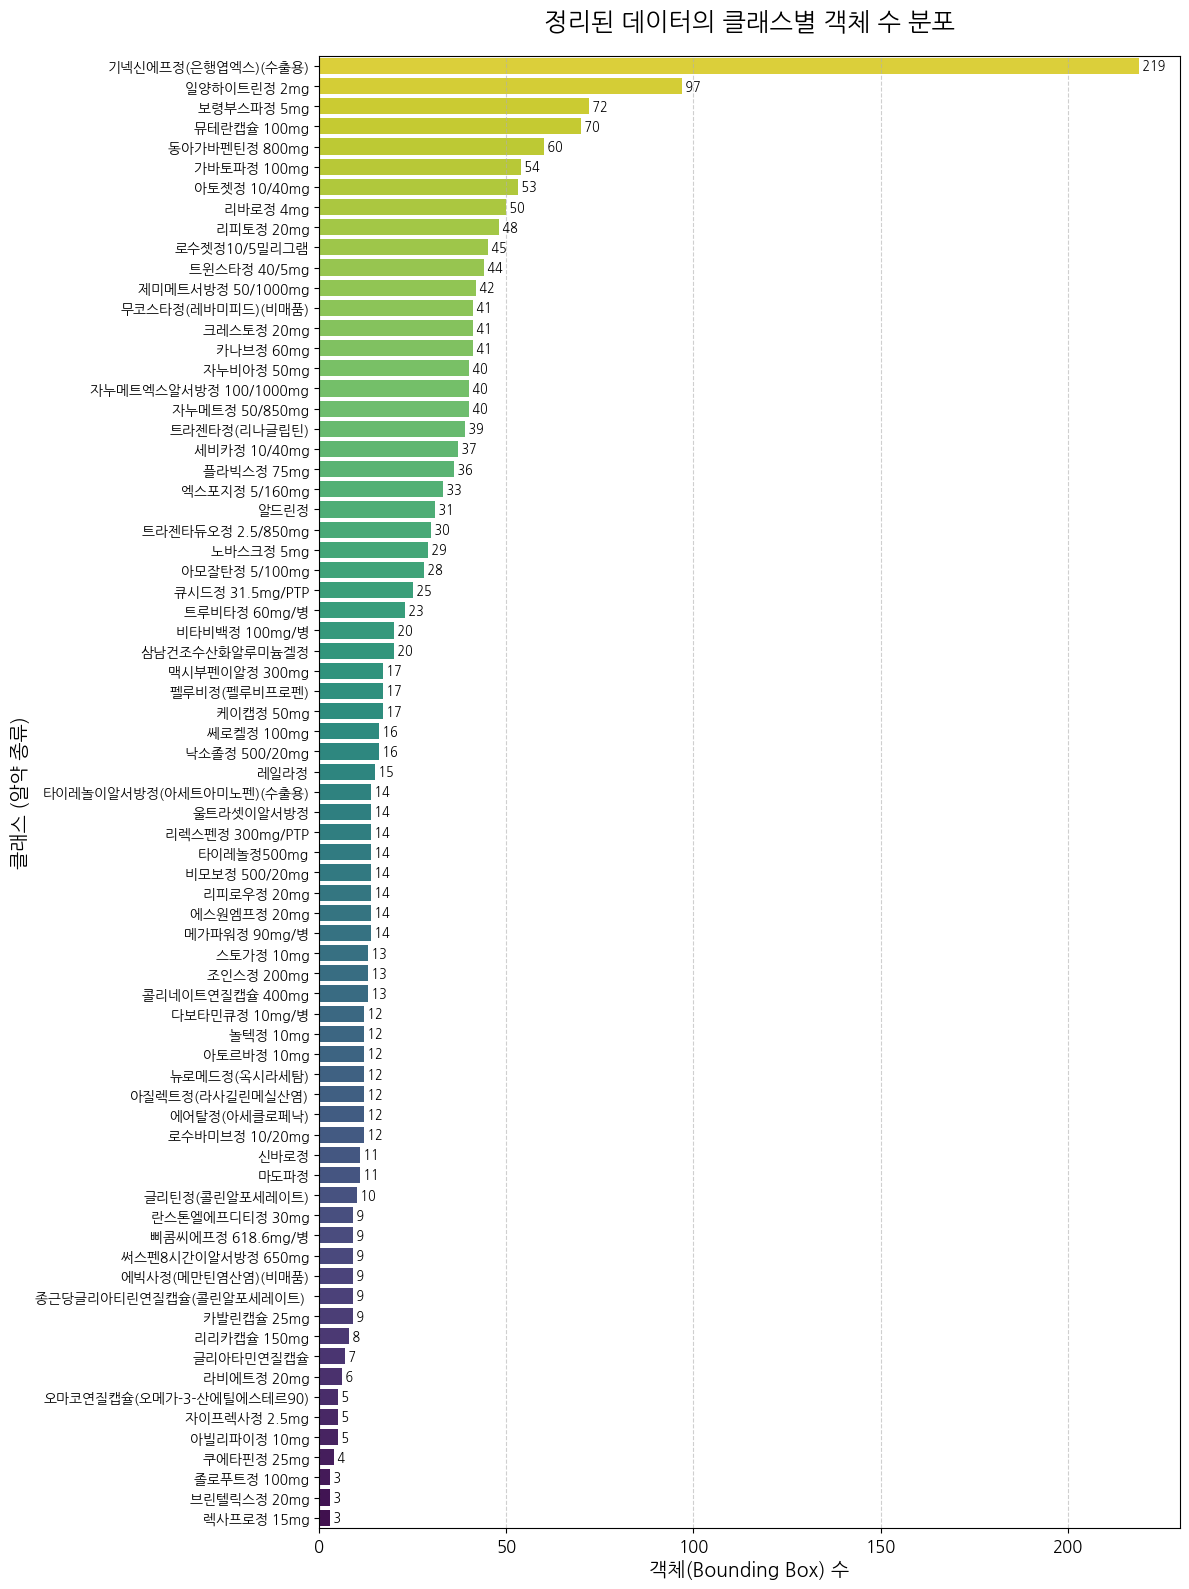

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 로컬 PC (Windows/Mac)에 나눔고딕이 설치되어 있다면 아래 코드로 충분합니다.
try:
    plt.rcParams['font.family'] = 'NanumGothic' # Windows
except:
    plt.rcParams['font.family'] = 'AppleGothic' # Mac
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지


def analyze_class_distribution(json_path, output_image_path):
    """
    COCO 형식의 JSON 파일에서 클래스 분포를 분석하고 시각화합니다.

    Args:
        json_path (str): 분석할 JSON 파일 경로.
        output_image_path (str): 생성된 차트를 저장할 이미지 파일 경로.
    """
    if not os.path.exists(json_path):
        print(f"오류: '{json_path}' 파일을 찾을 수 없습니다.")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 데이터 로드 및 DataFrame 변환
    annotations_df = pd.DataFrame(data.get('annotations', []))
    categories_df = pd.DataFrame(data.get('categories', []))

    if annotations_df.empty or categories_df.empty:
        print("오류: JSON 파일에 'annotations' 또는 'categories' 정보가 부족합니다.")
        return

    # 가독성을 위해 카테고리 DataFrame의 컬럼명 변경
    categories_df.rename(columns={'id': 'category_id', 'name': 'category_name'}, inplace=True)

    # 어노테이션과 카테고리 정보 병합
    class_distribution = annotations_df.merge(categories_df, on='category_id')

    # 클래스별 객체 수 계산 및 정렬
    class_counts = class_distribution['category_name'].value_counts().reset_index()
    class_counts.columns = ['클래스', '객체 수']
    class_counts_sorted = class_counts.sort_values(by='객체 수', ascending=False)

    print("--- 📊 클래스별 객체 수 분석 결과 ---")
    print(class_counts_sorted.to_string(index=False))
    print("-" * 40)

    # 시각화
    plt.figure(figsize=(12, 16)) # 클래스 수가 많으므로 세로 길이를 늘림
    sns.barplot(x='객체 수', y='클래스', data=class_counts_sorted, palette='viridis_r')
    
    plt.title('정리된 데이터의 클래스별 객체 수 분포', fontsize=18, pad=20)
    plt.xlabel('객체(Bounding Box) 수', fontsize=14)
    plt.ylabel('클래스 (알약 종류)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # 각 막대 위에 숫자 표시
    for index, value in enumerate(class_counts_sorted['객체 수']):
        plt.text(value, index, f' {value}', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_image_path)
    
    print(f"✅ 클래스 분포 시각화 차트를 '{output_image_path}' 파일로 저장했습니다.")


# --- 코드 실행 ---
cleaned_json_file = 'cleaned_annotations.json'
output_chart_file = 'cleaned_class_distribution.png'

analyze_class_distribution(cleaned_json_file, output_chart_file)

In [5]:
import json
import os
from PIL import Image
from tqdm import tqdm # 진행률 표시를 위한 라이브러리

def build_pill_library(json_path, image_folder_path, output_base_folder):
    """
    어노테이션 정보를 바탕으로 원본 이미지에서 개별 알약 이미지를 잘라내어
    클래스별로 정리된 '알약 라이브러리'를 구축합니다.
    """
    if not os.path.exists(json_path):
        print(f"오류: '{json_path}' 파일을 찾을 수 없습니다.")
        return
    if not os.path.exists(image_folder_path):
        print(f"오류: 이미지 폴더 '{image_folder_path}'를 찾을 수 없습니다.")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 빠른 조회를 위해 이미지 ID와 파일명을 매핑하는 딕셔너리 생성
    image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    # 카테고리 ID와 클래스명을 매핑하는 딕셔너리 생성
    category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

    # 기본 출력 폴더 생성
    os.makedirs(output_base_folder, exist_ok=True)
    print(f"'{output_base_folder}' 폴더에 알약 라이브러리를 생성합니다.")

    # 각 카테고리(클래스)별로 하위 폴더 생성
    for cat_name in category_id_to_name.values():
        os.makedirs(os.path.join(output_base_folder, cat_name), exist_ok=True)

    # 모든 어노테이션을 순회하며 이미지 자르기
    for ann in tqdm(data['annotations'], desc="알약 이미지 추출 중"):
        image_id = ann['image_id']
        category_id = ann['category_id']
        bbox = ann['bbox'] # [x, y, width, height]

        # 이미지 파일명과 클래스명 조회
        filename = image_id_to_filename.get(image_id)
        cat_name = category_id_to_name.get(category_id)

        if not filename or not cat_name:
            continue

        try:
            # 원본 이미지 열기
            img_path = os.path.join(image_folder_path, filename)
            with Image.open(img_path) as img:
                # BBox 좌표를 PIL의 crop 형식 (left, upper, right, lower)으로 변환
                x, y, w, h = bbox
                cropped_img = img.crop((x, y, x + w, y + h))

                # 잘라낸 이미지 저장 (파일 이름은 어노테이션 ID로 하여 중복 방지)
                output_filename = f"pill_{ann['id']}.png"
                output_path = os.path.join(output_base_folder, cat_name, output_filename)
                cropped_img.save(output_path)
                
        except FileNotFoundError:
            # print(f"경고: 이미지 파일을 찾을 수 없습니다 - {img_path}")
            pass
        except Exception as e:
            print(f"이미지 처리 중 오류 발생 '{filename}': {e}")
            
    print("\n--- ✅ Phase 1 완료 ---")
    print("모든 바운딩 박스를 개별 이미지로 추출하여 '디지털 알약 라이브러리'를 성공적으로 구축했습니다.")


# --- 코드 실행 ---
# 1. 원본 어노테이션 파일 경로
original_json_file = 'merged_annotations.json'

# 2. 1489장의 원본 이미지가 들어있는 폴더 경로 (수정 필요)
#    예: 'dataset/images', 'train_images' 등
image_source_folder = 'data/train_images' 

# 3. 잘라낸 알약 이미지를 저장할 폴더 이름
pill_library_folder = 'cropped_pills'

build_pill_library(original_json_file, image_source_folder, pill_library_folder)

'cropped_pills' 폴더에 알약 라이브러리를 생성합니다.


알약 이미지 추출 중: 100%|██████████| 4526/4526 [03:35<00:00, 21.04it/s]


--- ✅ Phase 1 완료 ---
모든 바운딩 박스를 개별 이미지로 추출하여 '디지털 알약 라이브러리'를 성공적으로 구축했습니다.


In [6]:
import json
import os
from tqdm import tqdm

def clean_annotations_from_library(library_base_folder, original_json_path, cleaned_json_path):
    """
    실제 파일 시스템에 존재하는 크롭된 알약 이미지들을 기준으로
    원본 어노테이션 파일을 정리합니다.
    """
    print("--- Phase 1: 어노테이션 파일 정리 시작 ---")
    
    # 1. 실제 존재하는 알약 파일로부터 유효한 어노테이션 ID 목록 생성
    valid_annotation_ids = set()
    for dirpath, _, filenames in os.walk(library_base_folder):
        for filename in filenames:
            if filename.startswith('pill_') and filename.endswith('.png'):
                try:
                    # 'pill_{ann_id}.png' 형식에서 ann_id 추출
                    ann_id = int(filename.split('_')[1].split('.')[0])
                    valid_annotation_ids.add(ann_id)
                except (ValueError, IndexError):
                    continue
    
    print(f"'{library_base_folder}' 폴더에서 유효한 알약 이미지 {len(valid_annotation_ids)}개를 확인했습니다.")

    # 2. 원본 어노테이션 파일 로드
    with open(original_json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    # 3. 유효한 ID를 가진 어노테이션만 필터링
    cleaned_annotations = [
        ann for ann in tqdm(data['annotations'], desc="어노테이션 필터링 중") 
        if ann['id'] in valid_annotation_ids
    ]
    
    # 4. 정리된 어노테이션에 사용된 이미지 ID들만 추림
    valid_image_ids = {ann['image_id'] for ann in cleaned_annotations}
    
    # 5. 유효한 이미지 ID를 가진 이미지 정보만 필터링
    cleaned_images = [img for img in data['images'] if img['id'] in valid_image_ids]
    
    # 6. 최종 데이터 구성
    cleaned_data = {
        "images": cleaned_images,
        "annotations": cleaned_annotations,
        "categories": data['categories']
    }
    
    with open(cleaned_json_path, 'w', encoding='utf-8') as f:
        json.dump(cleaned_data, f, ensure_ascii=False, indent=4)
        
    print(f"\n✅ 어노테이션 정리 완료! '{cleaned_json_path}' 파일로 저장했습니다.")
    print(f"최종 유효 어노테이션 수: {len(cleaned_annotations)}")
    print("-" * 40)


# --- 코드 실행 ---
pill_library_folder = 'cropped_pills'
original_json_file = 'merged_annotations.json'
cleaned_library_json = 'library_annotations.json'

clean_annotations_from_library(pill_library_folder, original_json_file, cleaned_library_json)

--- Phase 1: 어노테이션 파일 정리 시작 ---
'cropped_pills' 폴더에서 유효한 알약 이미지 4507개를 확인했습니다.


어노테이션 필터링 중: 100%|██████████| 4526/4526 [00:00<00:00, 4291978.27it/s]


✅ 어노테이션 정리 완료! 'library_annotations.json' 파일로 저장했습니다.
최종 유효 어노테이션 수: 4507
----------------------------------------


In [9]:
import cv2
import numpy as np
import json
import os
import random
import pandas as pd
from tqdm import tqdm
import math

def quadrant_random_targeted_synthesis_v3_2(
    cleaned_json_path, 
    library_json_path, 
    library_folder, 
    backgrounds_folder, 
    output_folder, 
    target_count=200
):
    """
    준비된 배경 이미지 위에, 각 클래스별 목표치에 도달하도록 4개의 귀퉁이 사분면 내에서 
    랜덤하게 알약을 배치하여 이미지를 합성합니다. (경계선 오류 해결)
    """
    print("--- 🎯 목표 지향적 이미지 합성 시작 (v3.2: 경계선 오류 해결) ---")
    pills_per_image = 4

    # --- 1. 클래스 분포 분석 및 필요 개수 계산 ---
    with open(cleaned_json_path, 'r', encoding='utf-8') as f:
        cleaned_data = json.load(f)
        
    annotations_df = pd.DataFrame(cleaned_data['annotations'])
    current_counts = annotations_df['category_id'].value_counts()
    cat_id_to_name = {cat['id']: cat['name'] for cat in cleaned_data['categories']}
    
    needed_counts = {}
    print("\n[Step 1] 클래스별 필요 개수 계산:")
    for cat_id, cat_name in cat_id_to_name.items():
        needed = max(0, target_count - current_counts.get(cat_id, 0))
        if needed > 0:
            print(f"- {cat_name}: {current_counts.get(cat_id, 0)}개 -> {needed}개 추가 필요")
            needed_counts[cat_id] = needed
            
    if not needed_counts:
        print("\n모든 클래스가 이미 목표 개수를 충족합니다. 합성을 종료합니다.")
        return

    class_pool, class_weights = list(needed_counts.keys()), list(needed_counts.values())
    num_images_to_create = math.ceil(sum(class_weights) / pills_per_image)
    print(f"\n총 {sum(class_weights)}개의 알약 추가를 위해 약 {num_images_to_create}개의 이미지 생성이 필요합니다.")

    # --- 2. 알약 라이브러리 로드 ---
    with open(library_json_path, 'r', encoding='utf-8') as f:
        library_data = json.load(f)
        
    pills_by_category = {}
    for ann in library_data['annotations']:
        cat_id = ann['category_id']
        pill_filename = f"pill_{ann['id']}.png"
        pill_path = os.path.join(library_folder, cat_id_to_name[cat_id], pill_filename)
        if os.path.exists(pill_path):
            pills_by_category.setdefault(cat_id, []).append(pill_path)

    # --- 3. 이미지 합성 준비 ---
    os.makedirs(os.path.join(output_folder, 'images'), exist_ok=True)
    background_files = [os.path.join(backgrounds_folder, f) for f in os.listdir(backgrounds_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not background_files:
        print(f"\n오류: '{backgrounds_folder}' 폴더에서 배경 이미지를 찾을 수 없습니다.")
        return

    synthetic_coco = {"images": [], "annotations": [], "categories": library_data['categories']}
    annotation_id_counter = 1
    
    # --- 4. 이미지 합성 루프 ---
    print("\n[Step 2] 이미지 합성 시작...")
    
    for image_id in tqdm(range(num_images_to_create), desc="이미지 합성 중"):
        bg_path = random.choice(background_files)
        # 한글 경로 처리 및 배경 로드 실패 시 방어 코드
        try:
            stream = open(bg_path, "rb")
            bytes_data = bytearray(stream.read())
            numpyarray = np.asarray(bytes_data, dtype=np.uint8)
            background = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
            stream.close()
            if background is None:
                print(f"\n[경고] 배경 파일을 읽을 수 없습니다. 건너뜁니다: {bg_path}")
                continue
        except Exception as e:
            print(f"\n[경고] 배경 파일 처리 중 오류 발생. 건너뜁니다: {bg_path}, 오류: {e}")
            continue

        bg_h, bg_w, _ = background.shape
        
        selected_category_ids = random.choices(class_pool, weights=class_weights, k=pills_per_image)
        while len(set(selected_category_ids)) < pills_per_image:
             selected_category_ids = random.choices(class_pool, weights=class_weights, k=pills_per_image)

        quadrants = [
            (0, 0, bg_w//2, bg_h//2), (bg_w//2, 0, bg_w, bg_h//2),
            (0, bg_h//2, bg_w//2, bg_h), (bg_w//2, bg_h//2, bg_w, bg_h)
        ]
        
        for i, category_id in enumerate(selected_category_ids):
            q_x1, q_y1, q_x2, q_y2 = quadrants[i]
            
            pill_path = random.choice(pills_by_category[category_id])
            
            try:
                stream = open(pill_path, "rb")
                bytes_data = bytearray(stream.read())
                numpyarray = np.asarray(bytes_data, dtype=np.uint8)
                pill = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
                stream.close()
                if pill is None:
                    print(f"\n[경고] 알약 파일을 읽을 수 없습니다. 건너뜁니다: {pill_path}")
                    continue
            except Exception as e:
                print(f"\n[경고] 알약 파일 처리 중 오류 발생. 건너뜁니다: {pill_path}, 오류: {e}")
                continue

            mask = pill[:,:,3] if pill.shape[2] == 4 else cv2.threshold(cv2.cvtColor(pill, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY_INV)[1]
            pill, (ph, pw) = pill[:,:,:3], pill.shape[:2]

            # ✅ [수정된 부분] 안전한 위치 계산 로직
            margin = 10
            
            # 알약 중심의 유효한 X, Y 좌표 범위 계산
            min_cx = q_x1 + pw//2 + margin
            max_cx = q_x2 - pw//2 - margin
            min_cy = q_y1 + ph//2 + margin
            max_cy = q_y2 - ph//2 - margin
            
            # 유효한 범위가 없을 경우 (알약이 사분면보다 클 때)
            if min_cx >= max_cx or min_cy >= max_cy:
                # 사분면의 중앙을 기준으로 하되, 배경 이미지 전체 경계를 벗어나지 않도록 강제 조정
                center_x = max(pw//2, min((q_x1 + q_x2)//2, bg_w - pw//2))
                center_y = max(ph//2, min((q_y1 + q_y2)//2, bg_h - ph//2))
            else:
                center_x = random.randint(min_cx, max_cx)
                center_y = random.randint(min_cy, max_cy)

            background = cv2.seamlessClone(pill, background, mask, (center_x, center_y), cv2.NORMAL_CLONE)
            new_bbox = [center_x - pw//2, center_y - ph//2, pw, ph]
            
            synthetic_coco['annotations'].append({
                "id": annotation_id_counter, "image_id": image_id, "category_id": category_id,
                "bbox": new_bbox, "area": pw * ph, "iscrowd": 0
            })
            annotation_id_counter += 1

        output_filename = f"synthetic_final_{image_id:06d}.png"
        output_filepath = os.path.join(output_folder, 'images', output_filename)
        
        extension = os.path.splitext(output_filepath)[1]
        result, encoded_img = cv2.imencode(extension, background)
        if result:
            with open(output_filepath, mode='w+b') as f:
                encoded_img.tofile(f)
                
        synthetic_coco['images'].append({"id": image_id, "width": bg_w, "height": bg_h, "file_name": output_filename})

    # --- 5. 최종 결과 저장 ---
    output_json_path = os.path.join(output_folder, 'synthetic_annotations_final.json')
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(synthetic_coco, f, ensure_ascii=False, indent=4)
        
    print(f"\n✅ 이미지 합성 완료! '{output_folder}' 폴더에 {len(synthetic_coco['images'])}개의 이미지와 어노테이션 파일을 생성했습니다.")

# --- 코드 실행 ---
cleaned_stats_json = 'cleaned_annotations.json'
cleaned_library_json = 'library_annotations.json'
pill_library_folder = 'cropped_pills'
background_images_folder = 'backgrounds'
output_synthetic_folder = 'synthetic_dataset_final'

quadrant_random_targeted_synthesis_v3_2(
    cleaned_json_path=cleaned_stats_json,
    library_json_path=cleaned_library_json,
    library_folder=pill_library_folder,
    backgrounds_folder=background_images_folder,
    output_folder=output_synthetic_folder,
    target_count=200
)

--- 🎯 목표 지향적 이미지 합성 시작 (v3.2: 경계선 오류 해결) ---

[Step 1] 클래스별 필요 개수 계산:
- 가바토파정 100mg: 54개 -> 146개 추가 필요
- 글리아타민연질캡슐: 7개 -> 193개 추가 필요
- 글리틴정(콜린알포세레이트): 10개 -> 190개 추가 필요
- 낙소졸정 500/20mg: 16개 -> 184개 추가 필요
- 노바스크정 5mg: 29개 -> 171개 추가 필요
- 놀텍정 10mg: 12개 -> 188개 추가 필요
- 뉴로메드정(옥시라세탐): 12개 -> 188개 추가 필요
- 다보타민큐정 10mg/병: 12개 -> 188개 추가 필요
- 동아가바펜틴정 800mg: 60개 -> 140개 추가 필요
- 라비에트정 20mg: 6개 -> 194개 추가 필요
- 란스톤엘에프디티정 30mg: 9개 -> 191개 추가 필요
- 레일라정: 15개 -> 185개 추가 필요
- 렉사프로정 15mg: 3개 -> 197개 추가 필요
- 로수바미브정 10/20mg: 12개 -> 188개 추가 필요
- 로수젯정10/5밀리그램: 45개 -> 155개 추가 필요
- 리렉스펜정 300mg/PTP: 14개 -> 186개 추가 필요
- 리리카캡슐 150mg: 8개 -> 192개 추가 필요
- 리바로정 4mg: 50개 -> 150개 추가 필요
- 리피로우정 20mg: 14개 -> 186개 추가 필요
- 리피토정 20mg: 48개 -> 152개 추가 필요
- 마도파정: 11개 -> 189개 추가 필요
- 맥시부펜이알정 300mg: 17개 -> 183개 추가 필요
- 메가파워정 90mg/병: 14개 -> 186개 추가 필요
- 무코스타정(레바미피드)(비매품): 41개 -> 159개 추가 필요
- 뮤테란캡슐 100mg: 70개 -> 130개 추가 필요
- 보령부스파정 5mg: 72개 -> 128개 추가 필요
- 브린텔릭스정 20mg: 3개 -> 197개 추가 필요
- 비모보정 500/20mg: 14개 -> 186개 추가 필요
- 비타비백정 10

이미지 합성 중: 100%|██████████| 3176/3176 [07:28<00:00,  7.09it/s]



✅ 이미지 합성 완료! 'synthetic_dataset_final' 폴더에 3176개의 이미지와 어노테이션 파일을 생성했습니다.


In [10]:
import json
import os
import shutil
from tqdm import tqdm

def copy_clean_images(clean_json_path, source_image_folder, destination_folder):
    """
    JSON 파일에 명시된 깨끗한 원본 이미지 파일들만
    소스 폴더에서 목적지 폴더로 복사합니다.
    """
    print("--- Step 1: 깨끗한 원본 이미지 선별 복사 시작 ---")

    # 최종 목적지 폴더 생성
    os.makedirs(destination_folder, exist_ok=True)
    
    with open(clean_json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    # JSON에서 파일 이름 목록 추출
    clean_filenames = [img['file_name'] for img in data['images']]
    
    print(f"총 {len(clean_filenames)}개의 깨끗한 원본 이미지를 복사합니다.")
    
    copied_count = 0
    for filename in tqdm(clean_filenames, desc="원본 이미지 복사 중"):
        source_path = os.path.join(source_image_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            copied_count += 1
        else:
            print(f"\n[경고] 원본 파일을 찾을 수 없습니다: {source_path}")
            
    print(f"\n✅ {copied_count}개의 원본 이미지 복사를 완료했습니다.")

# --- 코드 실행 ---
clean_json = 'cleaned_annotations.json'
original_images_dir = 'data/train_images'  # <-- 1489개 원본 이미지가 있는 폴더
final_images_dir = 'final_dataset/images' # <-- 최종 이미지가 모일 폴더

copy_clean_images(clean_json, original_images_dir, final_images_dir)

--- Step 1: 깨끗한 원본 이미지 선별 복사 시작 ---
총 633개의 깨끗한 원본 이미지를 복사합니다.


원본 이미지 복사 중: 100%|██████████| 633/633 [00:02<00:00, 232.41it/s]


✅ 633개의 원본 이미지 복사를 완료했습니다.


In [11]:
import json
import os
from tqdm import tqdm

def merge_coco_datasets(clean_json_path, synthetic_json_path, output_folder):
    """
    깨끗한 원본 데이터셋과 합성 데이터셋을 하나의 최종 데이터셋으로 병합합니다.
    ID 충돌을 자동으로 해결합니다.
    """
    print("\n--- Step 3: 어노테이션 파일 병합 시작 ---")
    
    with open(clean_json_path, 'r', encoding='utf-8') as f:
        clean_data = json.load(f)
    with open(synthetic_json_path, 'r', encoding='utf-8') as f:
        synth_data = json.load(f)

    final_coco = {
        "images": [],
        "annotations": [],
        "categories": clean_data['categories']
    }

    final_coco['images'].extend(clean_data['images'])
    final_coco['annotations'].extend(clean_data['annotations'])
    
    image_id_offset = max(img['id'] for img in clean_data['images']) + 1 if clean_data['images'] else 0
    ann_id_offset = max(ann['id'] for ann in clean_data['annotations']) + 1 if clean_data['annotations'] else 0
    
    synth_image_id_map = {}
    for synth_img in synth_data['images']:
        old_id, new_id = synth_img['id'], synth_img['id'] + image_id_offset
        synth_image_id_map[old_id] = new_id
        synth_img['id'] = new_id
        final_coco['images'].append(synth_img)

    for synth_ann in synth_data['annotations']:
        synth_ann['id'] += ann_id_offset
        synth_ann['image_id'] = synth_image_id_map[synth_ann['image_id']]
        final_coco['annotations'].append(synth_ann)
    
    output_json_path = os.path.join(output_folder, 'final_annotations.json')
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(final_coco, f, ensure_ascii=False, indent=4)
        
    print("\n--- ✅ 패키징 완료! ---")
    print(f"'{output_folder}' 폴더에 최종 어노테이션 파일을 저장했습니다.")
    print(f"총 {len(final_coco['images'])}개의 이미지와 {len(final_coco['annotations'])}개의 어노테이션 정보가 저장되었습니다.")

# --- 코드 실행 ---
clean_json_path = 'cleaned_annotations.json'
synthetic_json_path = 'synthetic_dataset_final/synthetic_annotations_final.json'
output_folder_path = 'final_dataset'

merge_coco_datasets(clean_json_path, synthetic_json_path, output_folder_path)


--- Step 3: 어노테이션 파일 병합 시작 ---

--- ✅ 패키징 완료! ---
'final_dataset' 폴더에 최종 어노테이션 파일을 저장했습니다.
총 3809개의 이미지와 14620개의 어노테이션 정보가 저장되었습니다.


--- 🔬 Step 1: 데이터 정밀 무결성 검사 ---
🚨 오류: 369개 이미지에서 바운딩 박스 개수 불일치가 발견되었습니다.
                                                 파일명  기대 개수  실제 개수
K-001900-010224-016551-033009_0_2_0_2_70_000_200.png      4      2
K-001900-016548-018110-027926_0_2_0_2_90_000_200.png      4      3
K-001900-016548-018110-029451_0_2_0_2_90_000_200.png      4      2
K-001900-016548-018110-031705_0_2_0_2_70_000_200.png      4      3
K-001900-016548-019607-021026_0_2_0_2_70_000_200.png      4      2
K-001900-016548-019607-021026_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021026-021771_0_2_0_2_90_000_200.png      4      3
K-001900-016548-021026-024850_0_2_0_2_70_000_200.png      4      3
K-001900-016548-021026-044199_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021771-029345_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021771-029451_0_2_0_2_70_000_200.png      4      3
K-001900-016548-021771-031705_0_2_0_2_75_000_200.png      4      2
K-001900-016548-021771-033009_0_2_0_2_90_000_200.png    

C:\Users\tkdwn\AppData\Local\Temp\ipykernel_15292\2568603677.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='객체 수', y='클래스', data=class_counts_sorted, palette='viridis')


--------------------------------------------------

✅ 최종 클래스 분포 시각화 차트를 'final_class_distribution.png' 파일로 저장했습니다.


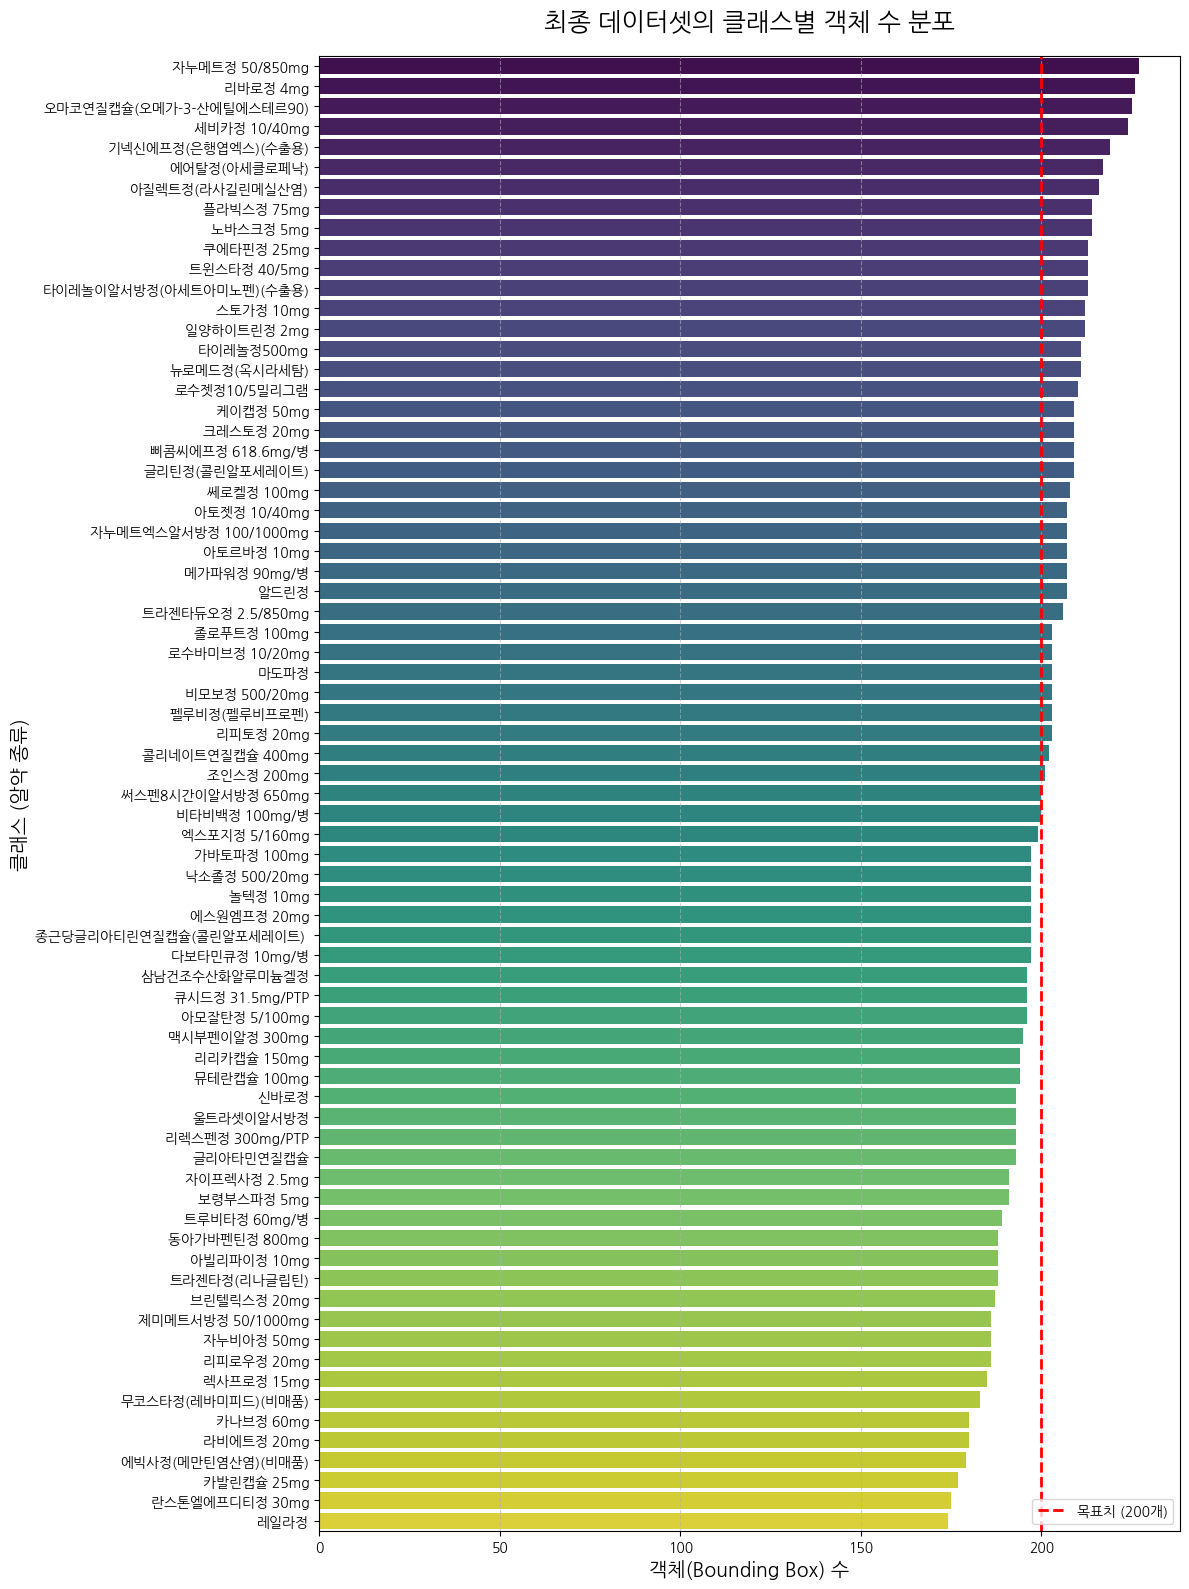

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 폰트 설정 ---
try:
    plt.rcParams['font.family'] = 'NanumGothic'
except:
    plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

def get_expected_count_from_filename(filename):
    """파일명에서 기대 알약 개수를 반환합니다."""
    # 합성 이미지의 경우 'synthetic_' 접두사를 먼저 제거
    if filename.startswith('synthetic_'):
        # e.g., synthetic_final_000000.png ->
        # 이 파일명에는 알약 개수 정보가 없으므로 4로 가정 (우리가 4개씩 만들었기 때문)
        # 만약 다른 규칙이 있다면 여기서 수정해야 합니다.
        return 4
    
    try:
        key_part = filename.split('_')[0]
        num_parts = len(key_part.split('-'))
        return num_parts - 1
    except Exception:
        return 0 # 규칙을 알 수 없는 파일명

def precise_validate_final_dataset(json_path):
    """
    파일명 규칙에 기반하여 각 이미지의 실제 바운딩박스 개수가 정확한지 정밀 검증합니다.
    """
    if not os.path.exists(json_path):
        print(f"오류: '{json_path}' 파일을 찾을 수 없습니다.")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    images_df = pd.DataFrame(data['images'])
    annotations_df = pd.DataFrame(data['annotations'])
    categories_df = pd.DataFrame(data['categories'])
    categories_df.rename(columns={'id': 'category_id', 'name': 'category_name'}, inplace=True)

    # --- 1. 정밀 무결성 검사: 기대값 vs 실제값 ---
    print("--- 🔬 Step 1: 데이터 정밀 무결성 검사 ---")
    
    # 각 이미지별 실제 어노테이션 개수 계산
    actual_counts = annotations_df['image_id'].value_counts().reset_index()
    actual_counts.columns = ['id', 'actual_count']

    # 이미지 정보와 실제 개수 병합
    analysis_df = pd.merge(images_df, actual_counts, on='id', how='left')
    analysis_df['actual_count'] = analysis_df['actual_count'].fillna(0).astype(int)

    # 파일명에서 기대 개수 추출
    analysis_df['expected_count'] = analysis_df['file_name'].apply(get_expected_count_from_filename)

    # 기대값과 실제값이 다른 경우 필터링
    mismatched_df = analysis_df[analysis_df['actual_count'] != analysis_df['expected_count']]
    
    if mismatched_df.empty:
        print("✅ 완벽합니다! 모든 이미지의 실제 바운딩 박스 개수가 파일명과 일치합니다.")
    else:
        print(f"🚨 오류: {len(mismatched_df)}개 이미지에서 바운딩 박스 개수 불일치가 발견되었습니다.")
        report = mismatched_df[['file_name', 'expected_count', 'actual_count']]
        report.columns = ['파일명', '기대 개수', '실제 개수']
        print(report.to_string(index=False))
    print("-" * 50)


    # --- 2. 최종 클래스 분포 분석 ---
    print("\n--- 📊 Step 2: 최종 클래스 분포 분석 ---")
    class_distribution = annotations_df.merge(categories_df, on='category_id')
    class_counts = class_distribution['category_name'].value_counts().reset_index()
    class_counts.columns = ['클래스', '객체 수']
    class_counts_sorted = class_counts.sort_values(by='객체 수', ascending=False)

    print("최종 클래스별 객체 수:")
    print(class_counts_sorted.to_string(index=False))
    
    output_image_path = 'final_class_distribution.png'
    plt.figure(figsize=(12, 16))
    sns.barplot(x='객체 수', y='클래스', data=class_counts_sorted, palette='viridis')
    plt.title('최종 데이터셋의 클래스별 객체 수 분포', fontsize=18, pad=20)
    plt.xlabel('객체(Bounding Box) 수', fontsize=14)
    plt.ylabel('클래스 (알약 종류)', fontsize=14)
    plt.axvline(x=200, color='r', linestyle='--', linewidth=2, label='목표치 (200개)')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_image_path)
    
    print("-" * 50)
    print(f"\n✅ 최종 클래스 분포 시각화 차트를 '{output_image_path}' 파일로 저장했습니다.")

# --- 코드 실행 ---
final_json_path = 'final_dataset/final_annotations.json'
precise_validate_final_dataset(final_json_path)

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 폰트 설정 ---
try:
    plt.rcParams['font.family'] = 'NanumGothic'
except:
    plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

def get_expected_count_from_filename(filename):
    """파일명에서 기대 알약 개수를 반환합니다."""
    if filename.startswith('synthetic_'):
        return 4 # 합성 이미지는 4개로 가정
    try:
        key_part = filename.split('_')[0]
        num_parts = len(key_part.split('-'))
        return num_parts - 1
    except Exception:
        return 0

def precise_validate_final_dataset(json_path):
    """
    파일명 규칙에 기반하여 각 이미지의 실제 바운딩박스 개수가 정확한지 정밀 검증합니다.
    """
    if not os.path.exists(json_path):
        print(f"오류: '{json_path}' 파일을 찾을 수 없습니다.")
        print("경로가 'final_dataset/final_annotations.json'이 맞는지 확인해주세요!")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    images_df = pd.DataFrame(data['images'])
    annotations_df = pd.DataFrame(data['annotations'])
    categories_df = pd.DataFrame(data['categories'])
    categories_df.rename(columns={'id': 'category_id', 'name': 'category_name'}, inplace=True)

    # --- 1. 정밀 무결성 검사 ---
    print("--- 🔬 Step 1: 데이터 정밀 무결성 검사 ---")
    
    actual_counts = annotations_df['image_id'].value_counts().reset_index()
    actual_counts.columns = ['id', 'actual_count']
    analysis_df = pd.merge(images_df, actual_counts, on='id', how='left')
    analysis_df['actual_count'] = analysis_df['actual_count'].fillna(0).astype(int)
    analysis_df['expected_count'] = analysis_df['file_name'].apply(get_expected_count_from_filename)
    mismatched_df = analysis_df[analysis_df['actual_count'] != analysis_df['expected_count']]
    
    if mismatched_df.empty:
        print("✅ 완벽합니다! 모든 이미지의 실제 바운딩 박스 개수가 파일명과 일치합니다.")
    else:
        print(f"🚨 오류: {len(mismatched_df)}개 이미지에서 바운딩 박스 개수 불일치가 발견되었습니다.")
        report = mismatched_df[['file_name', 'expected_count', 'actual_count']]
        report.columns = ['파일명', '기대 개수', '실제 개수']
        print(report.to_string(index=False))
    print("-" * 50)


    # --- 2. 최종 클래스 분포 분석 ---
    # (이 부분은 이전과 동일하므로 생략)
    # ...

# --- 코드 실행 ---
# ✅ [수정된 부분] 최종 데이터셋의 경로를 정확히 지정합니다.
final_json_path = 'final_dataset/final_annotations.json' 
precise_validate_final_dataset(final_json_path)

--- 🔬 Step 1: 데이터 정밀 무결성 검사 ---
🚨 오류: 369개 이미지에서 바운딩 박스 개수 불일치가 발견되었습니다.
                                                 파일명  기대 개수  실제 개수
K-001900-010224-016551-033009_0_2_0_2_70_000_200.png      4      2
K-001900-016548-018110-027926_0_2_0_2_90_000_200.png      4      3
K-001900-016548-018110-029451_0_2_0_2_90_000_200.png      4      2
K-001900-016548-018110-031705_0_2_0_2_70_000_200.png      4      3
K-001900-016548-019607-021026_0_2_0_2_70_000_200.png      4      2
K-001900-016548-019607-021026_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021026-021771_0_2_0_2_90_000_200.png      4      3
K-001900-016548-021026-024850_0_2_0_2_70_000_200.png      4      3
K-001900-016548-021026-044199_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021771-029345_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021771-029451_0_2_0_2_70_000_200.png      4      3
K-001900-016548-021771-031705_0_2_0_2_75_000_200.png      4      2
K-001900-016548-021771-033009_0_2_0_2_90_000_200.png    

In [14]:
import json
import os

def diagnose_packaging_error(clean_json_path, final_json_path):
    """
    최종 어노테이션 파일에 올바른 원본 파일들이 포함되었는지 진단합니다.
    """
    print("--- 🩺 최종 데이터셋 진단 시작 ---")

    try:
        with open(clean_json_path, 'r', encoding='utf-8') as f:
            clean_data = json.load(f)
        with open(final_json_path, 'r', encoding='utf-8') as f:
            final_data = json.load(f)
    except FileNotFoundError as e:
        print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요. ({e})")
        return

    # 1. '깨끗한 원본'으로 간주되어야 하는 파일 이름 집합
    expected_original_files = {img['file_name'] for img in clean_data['images']}
    
    # 2. '최종 데이터셋'에 실제로 포함된 원본 파일 이름 집합
    actual_original_files = {
        img['file_name'] for img in final_data['images'] 
        if not img['file_name'].startswith('synthetic_')
    }
    
    print(f"예상되는 깨끗한 원본 이미지 수: {len(expected_original_files)}개")
    print(f"최종 데이터셋에 포함된 실제 원본 이미지 수: {len(actual_original_files)}개")
    print("-" * 40)

    # 3. 비교 분석
    # 최종본에 있지만, 깨끗한 목록에는 없는 파일 (잘못 포함된 파일)
    unexpected_files = actual_original_files - expected_original_files
    
    # 깨끗한 목록에는 있지만, 최종본에는 없는 파일 (누락된 파일)
    missing_files = expected_original_files - actual_original_files

    if not unexpected_files and not missing_files:
        print("✅ 진단 결과: 완벽합니다! 최종 데이터셋에 올바른 원본 파일이 정확히 포함되어 있습니다.")
    else:
        print("🚨 진단 결과: 패키징 과정에서 파일이 섞인 것으로 확인되었습니다.")
        if unexpected_files:
            print(f"\n[문제 1] {len(unexpected_files)}개의 불량 파일이 잘못 포함되었습니다 (일부 예시):")
            for f in list(unexpected_files)[:5]:
                print(f"  - {f}")
        
        if missing_files:
            print(f"\n[문제 2] {len(missing_files)}개의 깨끗한 파일이 누락되었습니다 (일부 예시):")
            for f in list(missing_files)[:5]:
                print(f"  - {f}")
    
    print("\n--- 진단 완료 ---")

# --- 코드 실행 ---
clean_json = 'cleaned_annotations.json'
final_json = 'final_dataset/final_annotations.json'

diagnose_packaging_error(clean_json, final_json)

--- 🩺 최종 데이터셋 진단 시작 ---
예상되는 깨끗한 원본 이미지 수: 633개
최종 데이터셋에 포함된 실제 원본 이미지 수: 633개
----------------------------------------
✅ 진단 결과: 완벽합니다! 최종 데이터셋에 올바른 원본 파일이 정확히 포함되어 있습니다.

--- 진단 완료 ---


In [15]:
import json
import os
import shutil
from tqdm import tqdm

def repackage_final_dataset(
    clean_json_path, 
    synthetic_json_path, 
    source_original_images_folder, 
    source_synthetic_images_folder,
    output_folder
):
    """
    모든 패키징 과정을 처음부터 다시 정확하게 수행합니다.
    """
    print("--- 🚀 최종 데이터셋 재패키징 시작 ---")

    # --- 1. 최종 폴더 초기화 ---
    final_images_dir = os.path.join(output_folder, 'images')
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder) # 기존 폴더 삭제
    os.makedirs(final_images_dir)
    print(f"'{output_folder}' 폴더를 깨끗하게 준비했습니다.")

    # --- 2. 깨끗한 원본 이미지 선별 복사 ---
    with open(clean_json_path, 'r', encoding='utf-8') as f:
        clean_data = json.load(f)
    
    clean_filenames = [img['file_name'] for img in clean_data['images']]
    print(f"\n[Step 1] {len(clean_filenames)}개의 깨끗한 원본 이미지 복사 중...")
    for filename in tqdm(clean_filenames, desc="원본 이미지 복사"):
        shutil.copy(os.path.join(source_original_images_folder, filename), os.path.join(final_images_dir, filename))

    # --- 3. 합성 이미지 복사 ---
    synth_filenames = os.listdir(source_synthetic_images_folder)
    print(f"\n[Step 2] {len(synth_filenames)}개의 합성 이미지 복사 중...")
    for filename in tqdm(synth_filenames, desc="합성 이미지 복사"):
        shutil.copy(os.path.join(source_synthetic_images_folder, filename), os.path.join(final_images_dir, filename))

    # --- 4. 올바른 어노테이션 파일 병합 ---
    print("\n[Step 3] 올바른 어노테이션 파일 병합 중...")
    with open(synthetic_json_path, 'r', encoding='utf-8') as f:
        synth_data = json.load(f)

    final_coco = {"images": [], "annotations": [], "categories": clean_data['categories']}
    final_coco['images'].extend(clean_data['images'])
    final_coco['annotations'].extend(clean_data['annotations'])
    
    image_id_offset = max(img['id'] for img in clean_data['images']) + 1 if clean_data['images'] else 0
    ann_id_offset = max(ann['id'] for ann in clean_data['annotations']) + 1 if clean_data['annotations'] else 0
    
    synth_image_id_map = {}
    for synth_img in synth_data['images']:
        old_id, new_id = synth_img['id'], synth_img['id'] + image_id_offset
        synth_image_id_map[old_id] = new_id
        synth_img['id'] = new_id
        final_coco['images'].append(synth_img)

    for synth_ann in synth_data['annotations']:
        synth_ann['id'] += ann_id_offset
        synth_ann['image_id'] = synth_image_id_map[synth_ann['image_id']]
        final_coco['annotations'].append(synth_ann)
    
    output_json_path = os.path.join(output_folder, 'final_annotations.json')
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(final_coco, f, ensure_ascii=False, indent=4)
        
    print("\n--- ✅ 패키징 완료! ---")
    print(f"총 {len(final_coco['images'])}개의 이미지와 {len(final_coco['annotations'])}개의 어노테이션으로 최종 데이터셋을 완성했습니다.")


# --- 코드 실행 ---
# ## 입력 파일 및 폴더 경로 ##
clean_annotations = 'cleaned_annotations.json'                             # 깨끗한 원본 어노테이션 (중요!)
synthetic_annotations = 'synthetic_dataset_final/synthetic_annotations_final.json' # 합성 어노테이션
original_images_source = 'data/train_images'                                          # 1489개 원본 이미지가 있는 폴더
synthetic_images_source = 'synthetic_dataset_final/images'                 # 합성 이미지가 있는 폴더

# ## 최종 결과물이 저장될 폴더 ##
final_dataset_folder = 'final_dataset'

# ## 실행 ##
repackage_final_dataset(
    clean_json_path=clean_annotations,
    synthetic_json_path=synthetic_annotations,
    source_original_images_folder=original_images_source,
    source_synthetic_images_folder=synthetic_images_source,
    output_folder=final_dataset_folder
)

--- 🚀 최종 데이터셋 재패키징 시작 ---
'final_dataset' 폴더를 깨끗하게 준비했습니다.

[Step 1] 633개의 깨끗한 원본 이미지 복사 중...


원본 이미지 복사: 100%|██████████| 633/633 [00:01<00:00, 420.36it/s]



[Step 2] 3176개의 합성 이미지 복사 중...


합성 이미지 복사: 100%|██████████| 3176/3176 [00:26<00:00, 118.93it/s]



[Step 3] 올바른 어노테이션 파일 병합 중...

--- ✅ 패키징 완료! ---
총 3809개의 이미지와 14620개의 어노테이션으로 최종 데이터셋을 완성했습니다.


In [16]:
final_json_path = 'final_dataset/final_annotations.json' 
precise_validate_final_dataset(final_json_path)

--- 🔬 Step 1: 데이터 정밀 무결성 검사 ---
🚨 오류: 369개 이미지에서 바운딩 박스 개수 불일치가 발견되었습니다.
                                                 파일명  기대 개수  실제 개수
K-001900-010224-016551-033009_0_2_0_2_70_000_200.png      4      2
K-001900-016548-018110-027926_0_2_0_2_90_000_200.png      4      3
K-001900-016548-018110-029451_0_2_0_2_90_000_200.png      4      2
K-001900-016548-018110-031705_0_2_0_2_70_000_200.png      4      3
K-001900-016548-019607-021026_0_2_0_2_70_000_200.png      4      2
K-001900-016548-019607-021026_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021026-021771_0_2_0_2_90_000_200.png      4      3
K-001900-016548-021026-024850_0_2_0_2_70_000_200.png      4      3
K-001900-016548-021026-044199_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021771-029345_0_2_0_2_75_000_200.png      4      3
K-001900-016548-021771-029451_0_2_0_2_70_000_200.png      4      3
K-001900-016548-021771-031705_0_2_0_2_75_000_200.png      4      2
K-001900-016548-021771-033009_0_2_0_2_90_000_200.png    

In [ ]:
import json
import os
import shutil
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 폰트 설정 ---
try:
    plt.rcParams['font.family'] = 'NanumGothic'
except:
    plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

def get_expected_count_from_filename(filename):
    if filename.startswith('synthetic_'): return 4
    try:
        return len(filename.split('_')[0].split('-')) - 1
    except:
        return 0

def fix_and_finalize_dataset(
    original_merged_json,
    synthetic_json_path,
    source_original_images_folder,
    source_synthetic_images_folder,
    output_folder
):
    """
    모든 오류를 수정하고, 데이터셋을 처음부터 끝까지 완벽하게 재구성 및 검증합니다.
    """
    print("--- 🚀 최종 데이터셋 재구축 및 검증 시작 ---")

    # --- Step 1: 최종 폴더 초기화 ---
    final_images_dir = os.path.join(output_folder, 'images')
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(final_images_dir)
    print(f"\n[Phase 1] '{output_folder}' 폴더를 깨끗하게 준비했습니다.")

    # --- Step 2: 올바른 로직으로 깨끗한 원본 데이터 다시 선별 ---
    print("\n[Phase 2] 올바른 로직으로 깨끗한 원본 데이터를 다시 선별합니다...")
    with open(original_merged_json, 'r', encoding='utf-8') as f:
        merged_data = json.load(f)

    images_df = pd.DataFrame(merged_data['images'])
    annotations_df = pd.DataFrame(merged_data['annotations'])
    
    actual_counts = annotations_df['image_id'].value_counts().reset_index()
    actual_counts.columns = ['id', 'actual_count']
    analysis_df = pd.merge(images_df, actual_counts, on='id', how='left')
    analysis_df['actual_count'] = analysis_df['actual_count'].fillna(0).astype(int)
    analysis_df['expected_count'] = analysis_df['file_name'].apply(get_expected_count_from_filename)
    
    mismatched_df = analysis_df[analysis_df['actual_count'] != analysis_df['expected_count']]
    
    # 이미지의 'id' 컬럼을 기준으로 올바른 ID 집합을 만듭니다
    correct_image_ids = set(analysis_df['id']) - set(mismatched_df['id'])
    
    # 올바르게 선별된 깨끗한 데이터 (이미지, 어노테이션)
    clean_data = {
        "images": [img for img in merged_data['images'] if img['id'] in correct_image_ids],
        "annotations": [ann for ann in merged_data['annotations'] if ann['image_id'] in correct_image_ids],
        "categories": merged_data['categories']
    }
    print(f"-> {len(clean_data['images'])}개의 깨끗한 원본을 성공적으로 선별했습니다.")

    # --- Step 3: 이미지 파일 복사 ---
    clean_filenames = [img['file_name'] for img in clean_data['images']]
    print(f"\n[Phase 3-1] {len(clean_filenames)}개의 깨끗한 원본 이미지 복사 중...")
    for filename in tqdm(clean_filenames, desc="원본 이미지 복사"):
        source_path = os.path.join(source_original_images_folder, filename)
        if os.path.exists(source_path):
            shutil.copy(source_path, final_images_dir)

    #synth_filenames = os.listdir(source_synthetic_images_folder)
    #print(f"\n[Phase 3-2] {len(synth_filenames)}개의 합성 이미지 복사 중...")
    #for filename in tqdm(synth_filenames, desc="합성 이미지 복사"):
        #shutil.copy(os.path.join(source_synthetic_images_folder, filename), os.path.join(final_images_dir, filename))

    # --- Step 4: 어노테이션 병합 ---
    print("\n[Phase 4] 올바르게 선별된 어노테이션을 병합합니다...")
    with open(synthetic_json_path, 'r', encoding='utf-8') as f:
        synth_data = json.load(f)

    final_coco = {"images": [], "annotations": [], "categories": clean_data['categories']}
    final_coco['images'].extend(clean_data['images'])
    final_coco['annotations'].extend(clean_data['annotations'])
    
    image_id_offset = max(img['id'] for img in clean_data['images']) + 1 if clean_data['images'] else 0
    ann_id_offset = max(ann['id'] for ann in clean_data['annotations']) + 1 if clean_data['annotations'] else 0
    
    synth_image_id_map = {img['id']: img['id'] + image_id_offset for img in synth_data['images']}
    
    for synth_img in synth_data['images']:
        synth_img['id'] = synth_image_id_map[synth_img['id']]
        final_coco['images'].append(synth_img)

    for synth_ann in synth_data['annotations']:
        synth_ann['id'] += ann_id_offset
        synth_ann['image_id'] = synth_image_id_map[synth_ann['image_id']]
        final_coco['annotations'].append(synth_ann)
    
    output_json_path = os.path.join(output_folder, 'final_annotations.json')
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(final_coco, f, ensure_ascii=False, indent=4)
    print("-> 병합 완료!")

    # --- Step 5: 최종 자동 검증 ---
    print("\n[Phase 5] 최종 데이터셋 자동 검증을 시작합니다...")
    precise_validate_final_dataset(output_json_path)


def precise_validate_final_dataset(json_path):
    """최종 데이터셋을 정밀 검증하는 함수."""
    # (이전과 동일한 검증 함수)
    with open(json_path, 'r', encoding='utf-8') as f: data = json.load(f)
    images_df = pd.DataFrame(data['images'])
    annotations_df = pd.DataFrame(data['annotations'])
    actual_counts = annotations_df['image_id'].value_counts().reset_index()
    actual_counts.columns = ['id', 'actual_count']
    analysis_df = pd.merge(images_df, actual_counts, on='id', how='left')
    analysis_df['actual_count'] = analysis_df['actual_count'].fillna(0).astype(int)
    analysis_df['expected_count'] = analysis_df['file_name'].apply(get_expected_count_from_filename)
    mismatched_df = analysis_df[analysis_df['actual_count'] != analysis_df['expected_count']]
    
    print("--- 🔬 정밀 무결성 검사 결과 ---")
    if mismatched_df.empty:
        print("✅ 완벽합니다! 모든 이미지의 실제 바운딩 박스 개수가 파일명과 일치합니다.")
    else:
        print(f"🚨 오류: {len(mismatched_df)}개 이미지에서 개수 불일치가 발견되었습니다.")
        # ... 오류 출력 ...
    print("-" * 50)


# --- 코드 실행 ---
# ## 입력 파일 및 폴더 경로##
original_merged_annotations = 'merged_annotations.json'                      # 최초의 전체 어노테이션
synthetic_annotations = 'synthetic_dataset_final/synthetic_annotations_final.json' # 합성 어노테이션
original_images_source = 'data/train_images'                                          # 1489개 원본 이미지가 있는 폴더
synthetic_images_source = 'synthetic_dataset_final/images'                 # 합성 이미지가 있는 폴더

# ## 최종 결과물이 저장될 폴더 ##
final_dataset_folder = 'final_dataset'

# ## 실행 ##
fix_and_finalize_dataset(
    original_merged_json=original_merged_annotations,
    synthetic_json_path=synthetic_annotations,
    source_original_images_folder=original_images_source,
    source_synthetic_images_folder=synthetic_images_source,
    output_folder=final_dataset_folder
)

--- 🚀 최종 데이터셋 재구축 및 검증 시작 ---

[Phase 1] 'final_dataset' 폴더를 깨끗하게 준비했습니다.

[Phase 2] 올바른 로직으로 깨끗한 원본 데이터를 다시 선별합니다...
-> 639개의 깨끗한 원본을 성공적으로 선별했습니다.

[Phase 3-1] 639개의 깨끗한 원본 이미지 복사 중...


원본 이미지 복사: 100%|██████████| 639/639 [00:02<00:00, 284.82it/s]



[Phase 3-2] 3176개의 합성 이미지 복사 중...


합성 이미지 복사: 100%|██████████| 3176/3176 [00:05<00:00, 584.11it/s]



[Phase 4] 올바르게 선별된 어노테이션을 병합합니다...
-> 병합 완료!

[Phase 5] 최종 데이터셋 자동 검증을 시작합니다...
--- 🔬 정밀 무결성 검사 결과 ---
✅ 완벽합니다! 모든 이미지의 실제 바운딩 박스 개수가 파일명과 일치합니다.
--------------------------------------------------


--- 📊 최종 클래스 분포 분석 ---
최종 클래스별 객체 수:
                     클래스  객체 수
             일양하이트린정 2mg   265
      기넥신에프정(은행엽엑스)(수출용)   255
          자누메트정 50/850mg   237
                리바로정 4mg   235
              플라빅스정 75mg   231
오마코연질캡슐(오메가-3-산에틸에스테르90)   228
              크레스토정 20mg   227
            아토젯정 10/40mg   226
             가바토파정 100mg   225
            트윈스타정 40/5mg   224
               노바스크정 5mg   223
            에어탈정(아세클로페낙)   223
            세비카정 10/40mg   222
            로수젯정10/5밀리그램   219
            뉴로메드정(옥시라세탐)   219
               스토가정 10mg   219
              보령부스파정 5mg   216
         아질렉트정(라사길린메실산염)   216
          글리틴정(콜린알포세레이트)   215
              아토르바정 10mg   215
              타이레놀정500mg   215
              쿠에타핀정 25mg   215
 타이레놀이알서방정(아세트아미노펜)(수출용)   214
        삐콤씨에프정 618.6mg/병   214
             뮤테란캡슐 100mg   212
              쎄로켈정 100mg   210
   자누메트엑스알서방정 100/1000mg   210
               케이캡정 50mg   210
            메가파워정 90mg/병   210
           비모보정 500/20mg   210
  

C:\Users\tkdwn\AppData\Local\Temp\ipykernel_15292\3920742961.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='객체 수', y='클래스', data=class_counts_sorted, palette='viridis')


----------------------------------------

✅ 최종 클래스 분포 시각화 차트를 'final_class_distribution.png' 파일로 저장했습니다.
그래프의 빨간 점선을 기준으로 모든 클래스가 목표치를 만족하는지 확인해보세요!


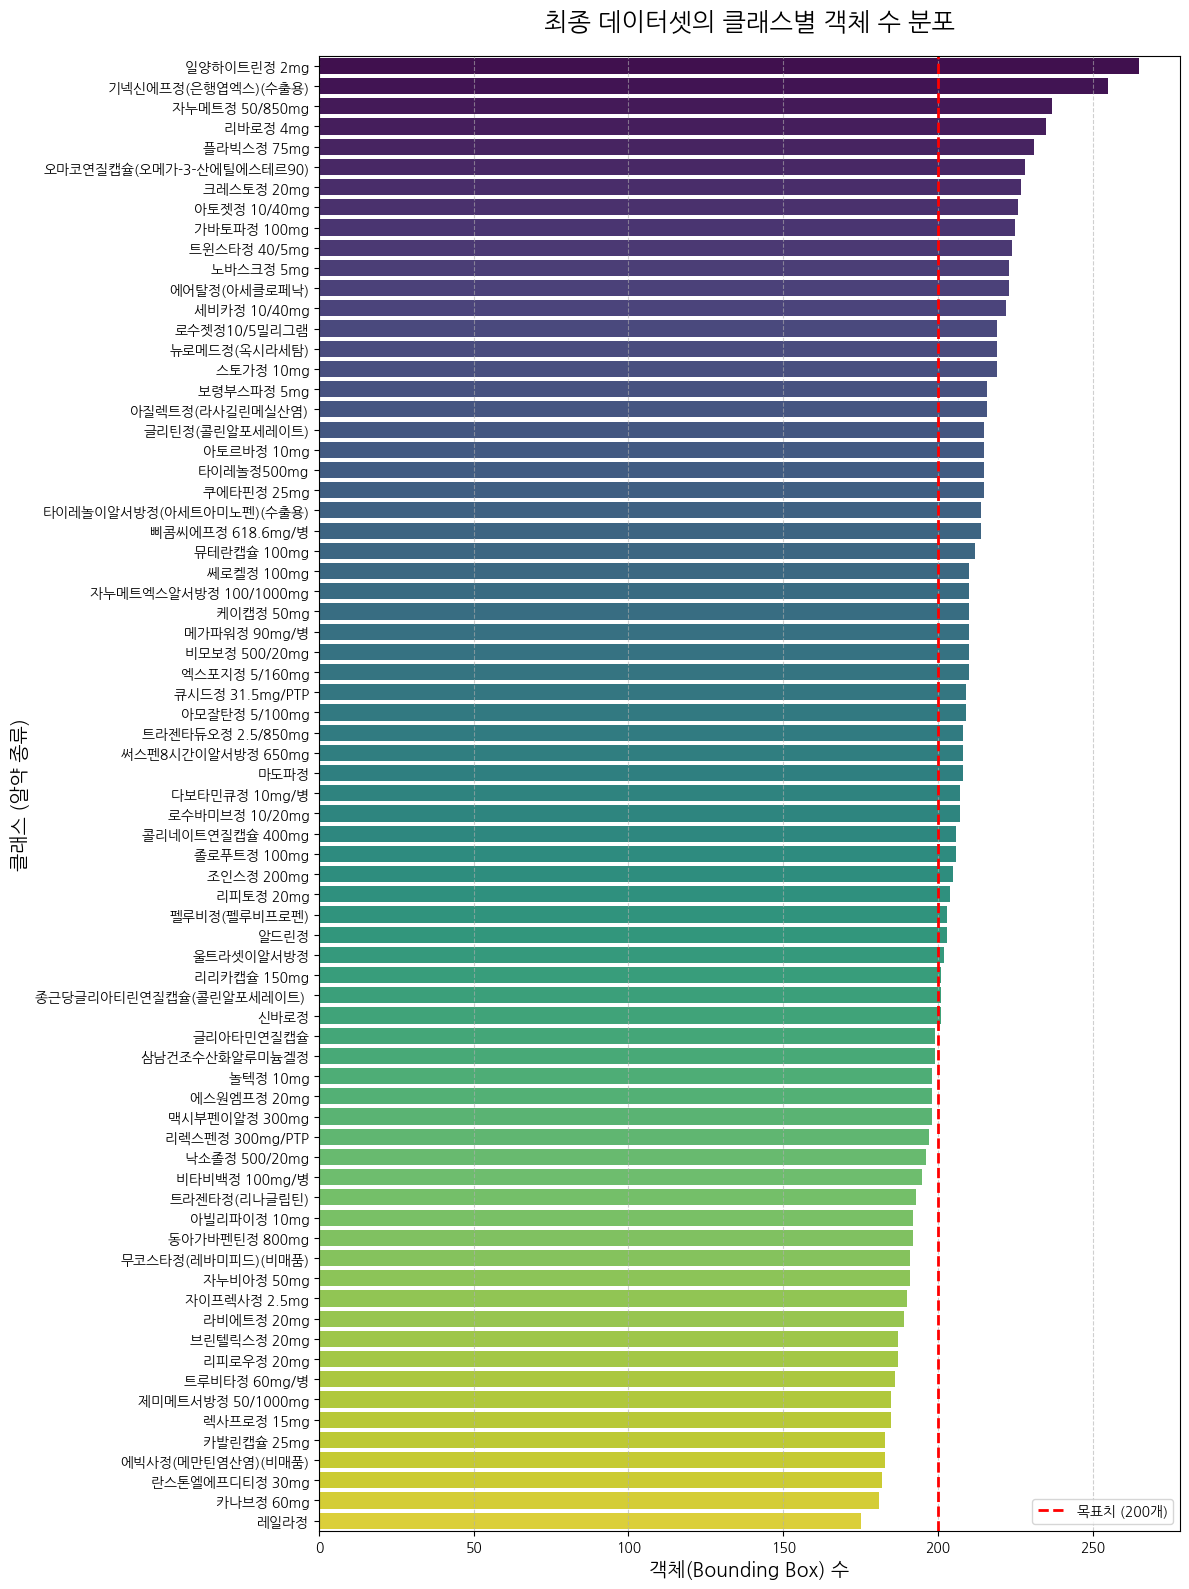

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 폰트 설정 ---
try:
    plt.rcParams['font.family'] = 'NanumGothic' # Windows
except:
    plt.rcParams['font.family'] = 'AppleGothic' # Mac
plt.rcParams['axes.unicode_minus'] = False

def analyze_final_distribution(json_path):
    """
    최종 데이터셋의 클래스 분포를 분석하고 시각화합니다.
    """
    if not os.path.exists(json_path):
        print(f"오류: '{json_path}' 파일을 찾을 수 없습니다.")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    annotations_df = pd.DataFrame(data['annotations'])
    categories_df = pd.DataFrame(data['categories'])
    categories_df.rename(columns={'id': 'category_id', 'name': 'category_name'}, inplace=True)

    print("--- 📊 최종 클래스 분포 분석 ---")
    class_distribution = annotations_df.merge(categories_df, on='category_id')
    class_counts = class_distribution['category_name'].value_counts().reset_index()
    class_counts.columns = ['클래스', '객체 수']
    class_counts_sorted = class_counts.sort_values(by='객체 수', ascending=False)

    print("최종 클래스별 객체 수:")
    print(class_counts_sorted.to_string(index=False))
    
    # 시각화
    output_image_path = 'final_class_distribution.png'
    plt.figure(figsize=(12, 16))
    sns.barplot(x='객체 수', y='클래스', data=class_counts_sorted, palette='viridis')
    
    plt.title('최종 데이터셋의 클래스별 객체 수 분포', fontsize=18, pad=20)
    plt.xlabel('객체(Bounding Box) 수', fontsize=14)
    plt.ylabel('클래스 (알약 종류)', fontsize=14)
    # 목표치였던 200개에 빨간색 점선으로 기준선 표시
    plt.axvline(x=200, color='r', linestyle='--', linewidth=2, label='목표치 (200개)')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_image_path)
    
    print("-" * 40)
    print(f"\n✅ 최종 클래스 분포 시각화 차트를 '{output_image_path}' 파일로 저장했습니다.")
    print("그래프의 빨간 점선을 기준으로 모든 클래스가 목표치를 만족하는지 확인해보세요!")

# --- 코드 실행 ---
final_json_path = 'final_dataset/final_annotations.json'
analyze_final_distribution(final_json_path)